In [2]:
'''
Krotov Algorithm for Quantum gate Implementation
Written By Bilal Riaz


'''
import matplotlib
import scipy.stats
import scipy.linalg
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as rnd
import scipy.linalg as LA
from scipy.integrate import ode


class Krotov:
    def __init__(self,J,lambda_1,ti,tf,steps):
        self.J = float(J)
        self.lambda_1 = float(lambda_1)
        self.ti = ti
        self.tf = tf
        self.steps = steps
        self.t = np.linspace(ti,tf,steps)

        self.dt = self.t[1] - self.t[0]
        self.sX = np.array([[0, 1], [1, 0]], dtype = 'complex64')
        self.sY = np.array([[0, -1j], [1j, 0]], dtype = 'complex64')
        self.sZ = np.array([[1, 0], [0, -1]], dtype = 'complex64')
        self.I = np.array(np.identity(2), dtype = 'complex64')

        self.sZZ = np.kron(self.sZ, self.sZ)
        self.sIY = np.kron(self.I, self.sY)
        self.sYI = np.kron(self.sY, self.I)
        self.sIZ = np.kron(self.I, self.sZ)
        self.sZI = np.kron(self.sZ, self.I)

        self.delta1 = 0
        self.alpha1 = 1
        self.delta2 = 1.9
        self.alpha2 = 0.3
        self.delta3 = 1.6
        self.alpha3 = 0.4
        self.delta4 = 1.6
        self.alpha4 = 0.4

       # seed is given values for better debugging and Design Purposes
        rnd.seed(0)
        
        omega = 10;
        
        # Controls
        self.EYI = np.zeros((self.steps,))
        #self.EYI_tilde = self.EYI
        self.EYI_tilde = np.zeros((self.steps,))
        self.EIY = 10 *rnd.rand(self.steps,) -5
        #self.EIY_tilde = self.EIY
        self.EIY_tilde = np.zeros((self.steps,))
        self.EZI = 10 *rnd.rand(self.steps,) -5
        #self.EZI_tilde = self.EZI
        self.EZI_tilde = np.zeros((self.steps,))
        self.EIZ = 10 *rnd.rand(self.steps,) -5
        #self.EIZ_tilde = self.EIZ
        self.EIZ_tilde = np.zeros((self.steps,))

        self.Ui = np.identity(4, dtype = 'complex128')
        self.UT = np.exp(-1j * np.pi/4)*np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0]], dtype = 'complex128')

        self.U = np.zeros([self.steps, 4, 4], dtype = 'complex128')
        self.B = np.zeros([self.steps, 4, 4], dtype = 'complex128')

        self.U[0] = np.identity(4, dtype = 'complex128')
        self.B[steps - 1] = self.UT.T.conj()

        self. Ho = self.J * self.sZZ

    def Hc(self, t_index):
        t = t_index
        return (self.EYI[t] * self.sYI + self.EIY[t] * self.sIY + self.EZI[t] * self.sZI + self.EIZ[t] * self.sIZ )

    def Hc_tilde(self, t_index):
        t = t_index
        return (self.EYI_tilde[t] * self.sYI + self.EIY_tilde[t] * self.sIY + self.EZI_tilde[t] * self.sZI + self.EIZ_tilde[t]* self.sIZ)

    def H(self, t_index):
        t = t_index
        return (self.Ho + self.Hc(t))

    def H_tilde(self, t_index):
        t = t_index
        return (self. Ho + self.Hc_tilde(t))

    def update_U (self, t_index):
        t = t_index
        self.U[t+1] = np.dot(LA.expm(-1j * self.H(t) * self.dt), self.U[t])

    def update_B (self, t_index):
        t = t_index
        self.B[t-1] = np.dot( self.B[t], LA.expm(-1j * self.H_tilde(t) * self.dt))

    def update_E(self, t_index):
        t=t_index

        EIYpart1 = (1-self.delta2) * self.EIY_tilde[t-1]
        EIYpart2 = -self.delta2 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sIY, self.U[t]) ) ) )/ self.alpha2
        self.EIY[t] = -(EIYpart1 + EIYpart2)

        EZIpart1 = (1-self.delta3) * self.EZI_tilde[t-1]
        EZIpart2 = -self.delta3 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sZI, self.U[t]) ) ) )/ self.alpha3
        self.EZI[t] = -(EZIpart1 + EZIpart2)

        EIZpart1 = (1-self.delta4) * self.EIZ_tilde[t-1]
        EIZpart2 = -self.delta4 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sIZ, self.U[t]) ) ) )/ self.alpha4
        self.EIZ[t] = -(EIZpart1 + EIZpart2)


    def update_E_tilde(self,t_index):
        t=t_index

        EIYpart1 = (1-self.delta2) * self.EIY[t]
        EIYpart2 = -self.delta2 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sIY, self.U[t]) ) ) )/ self.alpha2
        self.EIY_tilde[t] = -(EIYpart1 + EIYpart2)

        EZIpart1 = (1-self.delta3) * self.EZI[t]
        EZIpart2 = -self.delta3 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sZI, self.U[t]) ) ) )/ self.alpha3
        self.EZI_tilde[t] = -(EZIpart1 + EZIpart2)

        EIZpart1 = (1-self.delta4) * self.EIZ[t]
        EIZpart2 = -self.delta4 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sIZ, self.U[t]) ) ) )/ self.alpha4
        self.EIZ_tilde[t] = -(EIZpart1 + EIZpart2)

    def evolution_U(self,string='not initial'):
        if string == 'initial':
            for t in range(0,self.steps-1):
                self.update_U(t)
        else:
            for t in range(0,self.steps-1):
                self.update_E(t)
                self.update_U(t)
            t = self.steps-1
            self.update_E(t)

    def evolution_B(self):
        for t in range(self.steps-1,0,-1):
            self.update_E_tilde(t)
            self.update_B(t)
        t = 0
        self.update_E_tilde(t)

    def O(self,step):
        t = step
        return( np.dot(self.UT.conj().T, self.U[t] ))
    # Some methods might seem redundant but they are maintained to solve complicated optimal control problems in future
    # Better Structured Toolboxes can give 
    def Overlap(self, t_index ):
        t = t_index
        return( np.abs(np.trace(self.O(t))))

    def distance(self,t_index):
        t= t_index
        return(LA.norm(self.UT - self.U[t], 'fro'))

    def Run_Krotov(self, num_iter):
        T = self.steps-1
        self.evolution_U('initial')
        self.overlap = np.zeros([num_iter,1], dtype = 'float64')
        self.dis = np.zeros([num_iter,1], dtype = 'float64')

        for i in range(0,num_iter):
            print ("Cycle : " + str(i))
            #print (str(self.overlap[i]))
            self.B[T] = self.UT.conj().T
            self.evolution_B()
            self.evolution_U()
            self.overlap[i] = self.Overlap(T)
            self.dis[i] = self.distance(T)


Cycle : 0
Cycle : 1
Cycle : 2
Cycle : 3
Cycle : 4
Cycle : 5
Cycle : 6
Cycle : 7
Cycle : 8
Cycle : 9
Cycle : 10
Cycle : 11
Cycle : 12
Cycle : 13
Cycle : 14
Cycle : 15
Cycle : 16
Cycle : 17
Cycle : 18
Cycle : 19
Cycle : 20
Cycle : 21
Cycle : 22
Cycle : 23
Cycle : 24
Cycle : 25
Cycle : 26
Cycle : 27
Cycle : 28
Cycle : 29
Cycle : 30
Cycle : 31
Cycle : 32
Cycle : 33
Cycle : 34
Cycle : 35
Cycle : 36
Cycle : 37
Cycle : 38
Cycle : 39
Cycle : 40
Cycle : 41
Cycle : 42
Cycle : 43
Cycle : 44
Cycle : 45
Cycle : 46
Cycle : 47
Cycle : 48
Cycle : 49
Cycle : 50
Cycle : 51
Cycle : 52
Cycle : 53
Cycle : 54
Cycle : 55
Cycle : 56
Cycle : 57
Cycle : 58
Cycle : 59
Cycle : 60
Cycle : 61
Cycle : 62
Cycle : 63
Cycle : 64
Cycle : 65
Cycle : 66
Cycle : 67
Cycle : 68
Cycle : 69
Cycle : 70
Cycle : 71
Cycle : 72
Cycle : 73
Cycle : 74
Cycle : 75
Cycle : 76
Cycle : 77
Cycle : 78
Cycle : 79
Cycle : 80
Cycle : 81
Cycle : 82
Cycle : 83
Cycle : 84
Cycle : 85
Cycle : 86
Cycle : 87
Cycle : 88
Cycle : 89
Cycle : 90
Cycle : 9

Cycle : 692
Cycle : 693
Cycle : 694
Cycle : 695
Cycle : 696
Cycle : 697
Cycle : 698
Cycle : 699
Cycle : 700
Cycle : 701
Cycle : 702
Cycle : 703
Cycle : 704
Cycle : 705
Cycle : 706
Cycle : 707
Cycle : 708
Cycle : 709
Cycle : 710
Cycle : 711
Cycle : 712
Cycle : 713
Cycle : 714
Cycle : 715
Cycle : 716
Cycle : 717
Cycle : 718
Cycle : 719
Cycle : 720
Cycle : 721
Cycle : 722
Cycle : 723
Cycle : 724
Cycle : 725
Cycle : 726
Cycle : 727
Cycle : 728
Cycle : 729
Cycle : 730
Cycle : 731
Cycle : 732
Cycle : 733
Cycle : 734
Cycle : 735
Cycle : 736
Cycle : 737
Cycle : 738
Cycle : 739
Cycle : 740
Cycle : 741
Cycle : 742
Cycle : 743
Cycle : 744
Cycle : 745
Cycle : 746
Cycle : 747
Cycle : 748
Cycle : 749
Cycle : 750
Cycle : 751
Cycle : 752
Cycle : 753
Cycle : 754
Cycle : 755
Cycle : 756
Cycle : 757
Cycle : 758
Cycle : 759
Cycle : 760
Cycle : 761
Cycle : 762
Cycle : 763
Cycle : 764
Cycle : 765
Cycle : 766
Cycle : 767
Cycle : 768
Cycle : 769
Cycle : 770
Cycle : 771
Cycle : 772
Cycle : 773
Cycle : 774
Cycl

Cycle : 1346
Cycle : 1347
Cycle : 1348
Cycle : 1349
Cycle : 1350
Cycle : 1351
Cycle : 1352
Cycle : 1353
Cycle : 1354
Cycle : 1355
Cycle : 1356
Cycle : 1357
Cycle : 1358
Cycle : 1359
Cycle : 1360
Cycle : 1361
Cycle : 1362
Cycle : 1363
Cycle : 1364
Cycle : 1365
Cycle : 1366
Cycle : 1367
Cycle : 1368
Cycle : 1369
Cycle : 1370
Cycle : 1371
Cycle : 1372
Cycle : 1373
Cycle : 1374
Cycle : 1375
Cycle : 1376
Cycle : 1377
Cycle : 1378
Cycle : 1379
Cycle : 1380
Cycle : 1381
Cycle : 1382
Cycle : 1383
Cycle : 1384
Cycle : 1385
Cycle : 1386
Cycle : 1387
Cycle : 1388
Cycle : 1389
Cycle : 1390
Cycle : 1391
Cycle : 1392
Cycle : 1393
Cycle : 1394
Cycle : 1395
Cycle : 1396
Cycle : 1397
Cycle : 1398
Cycle : 1399
Cycle : 1400
Cycle : 1401
Cycle : 1402
Cycle : 1403
Cycle : 1404
Cycle : 1405
Cycle : 1406
Cycle : 1407
Cycle : 1408
Cycle : 1409
Cycle : 1410
Cycle : 1411
Cycle : 1412
Cycle : 1413
Cycle : 1414
Cycle : 1415
Cycle : 1416
Cycle : 1417
Cycle : 1418
Cycle : 1419
Cycle : 1420
Cycle : 1421
Cycle : 1422

Cycle : 1977
Cycle : 1978
Cycle : 1979
Cycle : 1980
Cycle : 1981
Cycle : 1982
Cycle : 1983
Cycle : 1984
Cycle : 1985
Cycle : 1986
Cycle : 1987
Cycle : 1988
Cycle : 1989
Cycle : 1990
Cycle : 1991
Cycle : 1992
Cycle : 1993
Cycle : 1994
Cycle : 1995
Cycle : 1996
Cycle : 1997
Cycle : 1998
Cycle : 1999
Cycle : 2000
Cycle : 2001
Cycle : 2002
Cycle : 2003
Cycle : 2004
Cycle : 2005
Cycle : 2006
Cycle : 2007
Cycle : 2008
Cycle : 2009
Cycle : 2010
Cycle : 2011
Cycle : 2012
Cycle : 2013
Cycle : 2014
Cycle : 2015
Cycle : 2016
Cycle : 2017
Cycle : 2018
Cycle : 2019
Cycle : 2020
Cycle : 2021
Cycle : 2022
Cycle : 2023
Cycle : 2024
Cycle : 2025
Cycle : 2026
Cycle : 2027
Cycle : 2028
Cycle : 2029
Cycle : 2030
Cycle : 2031
Cycle : 2032
Cycle : 2033
Cycle : 2034
Cycle : 2035
Cycle : 2036
Cycle : 2037
Cycle : 2038
Cycle : 2039
Cycle : 2040
Cycle : 2041
Cycle : 2042
Cycle : 2043
Cycle : 2044
Cycle : 2045
Cycle : 2046
Cycle : 2047
Cycle : 2048
Cycle : 2049
Cycle : 2050
Cycle : 2051
Cycle : 2052
Cycle : 2053

Cycle : 2608
Cycle : 2609
Cycle : 2610
Cycle : 2611
Cycle : 2612
Cycle : 2613
Cycle : 2614
Cycle : 2615
Cycle : 2616
Cycle : 2617
Cycle : 2618
Cycle : 2619
Cycle : 2620
Cycle : 2621
Cycle : 2622
Cycle : 2623
Cycle : 2624
Cycle : 2625
Cycle : 2626
Cycle : 2627
Cycle : 2628
Cycle : 2629
Cycle : 2630
Cycle : 2631
Cycle : 2632
Cycle : 2633
Cycle : 2634
Cycle : 2635
Cycle : 2636
Cycle : 2637
Cycle : 2638
Cycle : 2639
Cycle : 2640
Cycle : 2641
Cycle : 2642
Cycle : 2643
Cycle : 2644
Cycle : 2645
Cycle : 2646
Cycle : 2647
Cycle : 2648
Cycle : 2649
Cycle : 2650
Cycle : 2651
Cycle : 2652
Cycle : 2653
Cycle : 2654
Cycle : 2655
Cycle : 2656
Cycle : 2657
Cycle : 2658
Cycle : 2659
Cycle : 2660
Cycle : 2661
Cycle : 2662
Cycle : 2663
Cycle : 2664
Cycle : 2665
Cycle : 2666
Cycle : 2667
Cycle : 2668
Cycle : 2669
Cycle : 2670
Cycle : 2671
Cycle : 2672
Cycle : 2673
Cycle : 2674
Cycle : 2675
Cycle : 2676
Cycle : 2677
Cycle : 2678
Cycle : 2679
Cycle : 2680
Cycle : 2681
Cycle : 2682
Cycle : 2683
Cycle : 2684

Cycle : 3239
Cycle : 3240
Cycle : 3241
Cycle : 3242
Cycle : 3243
Cycle : 3244
Cycle : 3245
Cycle : 3246
Cycle : 3247
Cycle : 3248
Cycle : 3249
Cycle : 3250
Cycle : 3251
Cycle : 3252
Cycle : 3253
Cycle : 3254
Cycle : 3255
Cycle : 3256
Cycle : 3257
Cycle : 3258
Cycle : 3259
Cycle : 3260
Cycle : 3261
Cycle : 3262
Cycle : 3263
Cycle : 3264
Cycle : 3265
Cycle : 3266
Cycle : 3267
Cycle : 3268
Cycle : 3269
Cycle : 3270
Cycle : 3271
Cycle : 3272
Cycle : 3273
Cycle : 3274
Cycle : 3275
Cycle : 3276
Cycle : 3277
Cycle : 3278
Cycle : 3279
Cycle : 3280
Cycle : 3281
Cycle : 3282
Cycle : 3283
Cycle : 3284
Cycle : 3285
Cycle : 3286
Cycle : 3287
Cycle : 3288
Cycle : 3289
Cycle : 3290
Cycle : 3291
Cycle : 3292
Cycle : 3293
Cycle : 3294
Cycle : 3295
Cycle : 3296
Cycle : 3297
Cycle : 3298
Cycle : 3299
Cycle : 3300
Cycle : 3301
Cycle : 3302
Cycle : 3303
Cycle : 3304
Cycle : 3305
Cycle : 3306
Cycle : 3307
Cycle : 3308
Cycle : 3309
Cycle : 3310
Cycle : 3311
Cycle : 3312
Cycle : 3313
Cycle : 3314
Cycle : 3315

Cycle : 3870
Cycle : 3871
Cycle : 3872
Cycle : 3873
Cycle : 3874
Cycle : 3875
Cycle : 3876
Cycle : 3877
Cycle : 3878
Cycle : 3879
Cycle : 3880
Cycle : 3881
Cycle : 3882
Cycle : 3883
Cycle : 3884
Cycle : 3885
Cycle : 3886
Cycle : 3887
Cycle : 3888
Cycle : 3889
Cycle : 3890
Cycle : 3891
Cycle : 3892
Cycle : 3893
Cycle : 3894
Cycle : 3895
Cycle : 3896
Cycle : 3897
Cycle : 3898
Cycle : 3899
Cycle : 3900
Cycle : 3901
Cycle : 3902
Cycle : 3903
Cycle : 3904
Cycle : 3905
Cycle : 3906
Cycle : 3907
Cycle : 3908
Cycle : 3909
Cycle : 3910
Cycle : 3911
Cycle : 3912
Cycle : 3913
Cycle : 3914
Cycle : 3915
Cycle : 3916
Cycle : 3917
Cycle : 3918
Cycle : 3919
Cycle : 3920
Cycle : 3921
Cycle : 3922
Cycle : 3923
Cycle : 3924
Cycle : 3925
Cycle : 3926
Cycle : 3927
Cycle : 3928
Cycle : 3929
Cycle : 3930
Cycle : 3931
Cycle : 3932
Cycle : 3933
Cycle : 3934
Cycle : 3935
Cycle : 3936
Cycle : 3937
Cycle : 3938
Cycle : 3939
Cycle : 3940
Cycle : 3941
Cycle : 3942
Cycle : 3943
Cycle : 3944
Cycle : 3945
Cycle : 3946

Cycle : 4501
Cycle : 4502
Cycle : 4503
Cycle : 4504
Cycle : 4505
Cycle : 4506
Cycle : 4507
Cycle : 4508
Cycle : 4509
Cycle : 4510
Cycle : 4511
Cycle : 4512
Cycle : 4513
Cycle : 4514
Cycle : 4515
Cycle : 4516
Cycle : 4517
Cycle : 4518
Cycle : 4519
Cycle : 4520
Cycle : 4521
Cycle : 4522
Cycle : 4523
Cycle : 4524
Cycle : 4525
Cycle : 4526
Cycle : 4527
Cycle : 4528
Cycle : 4529
Cycle : 4530
Cycle : 4531
Cycle : 4532
Cycle : 4533
Cycle : 4534
Cycle : 4535
Cycle : 4536
Cycle : 4537
Cycle : 4538
Cycle : 4539
Cycle : 4540
Cycle : 4541
Cycle : 4542
Cycle : 4543
Cycle : 4544
Cycle : 4545
Cycle : 4546
Cycle : 4547
Cycle : 4548
Cycle : 4549
Cycle : 4550
Cycle : 4551
Cycle : 4552
Cycle : 4553
Cycle : 4554
Cycle : 4555
Cycle : 4556
Cycle : 4557
Cycle : 4558
Cycle : 4559
Cycle : 4560
Cycle : 4561
Cycle : 4562
Cycle : 4563
Cycle : 4564
Cycle : 4565
Cycle : 4566
Cycle : 4567
Cycle : 4568
Cycle : 4569
Cycle : 4570
Cycle : 4571
Cycle : 4572
Cycle : 4573
Cycle : 4574
Cycle : 4575
Cycle : 4576
Cycle : 4577

Cycle : 5132
Cycle : 5133
Cycle : 5134
Cycle : 5135
Cycle : 5136
Cycle : 5137
Cycle : 5138
Cycle : 5139
Cycle : 5140
Cycle : 5141
Cycle : 5142
Cycle : 5143
Cycle : 5144
Cycle : 5145
Cycle : 5146
Cycle : 5147
Cycle : 5148
Cycle : 5149
Cycle : 5150
Cycle : 5151
Cycle : 5152
Cycle : 5153
Cycle : 5154
Cycle : 5155
Cycle : 5156
Cycle : 5157
Cycle : 5158
Cycle : 5159
Cycle : 5160
Cycle : 5161
Cycle : 5162
Cycle : 5163
Cycle : 5164
Cycle : 5165
Cycle : 5166
Cycle : 5167
Cycle : 5168
Cycle : 5169
Cycle : 5170
Cycle : 5171
Cycle : 5172
Cycle : 5173
Cycle : 5174
Cycle : 5175
Cycle : 5176
Cycle : 5177
Cycle : 5178
Cycle : 5179
Cycle : 5180
Cycle : 5181
Cycle : 5182
Cycle : 5183
Cycle : 5184
Cycle : 5185
Cycle : 5186
Cycle : 5187
Cycle : 5188
Cycle : 5189
Cycle : 5190
Cycle : 5191
Cycle : 5192
Cycle : 5193
Cycle : 5194
Cycle : 5195
Cycle : 5196
Cycle : 5197
Cycle : 5198
Cycle : 5199
Cycle : 5200
Cycle : 5201
Cycle : 5202
Cycle : 5203
Cycle : 5204
Cycle : 5205
Cycle : 5206
Cycle : 5207
Cycle : 5208

Cycle : 5763
Cycle : 5764
Cycle : 5765
Cycle : 5766
Cycle : 5767
Cycle : 5768
Cycle : 5769
Cycle : 5770
Cycle : 5771
Cycle : 5772
Cycle : 5773
Cycle : 5774
Cycle : 5775
Cycle : 5776
Cycle : 5777
Cycle : 5778
Cycle : 5779
Cycle : 5780
Cycle : 5781
Cycle : 5782
Cycle : 5783
Cycle : 5784
Cycle : 5785
Cycle : 5786
Cycle : 5787
Cycle : 5788
Cycle : 5789
Cycle : 5790
Cycle : 5791
Cycle : 5792
Cycle : 5793
Cycle : 5794
Cycle : 5795
Cycle : 5796
Cycle : 5797
Cycle : 5798
Cycle : 5799
Cycle : 5800
Cycle : 5801
Cycle : 5802
Cycle : 5803
Cycle : 5804
Cycle : 5805
Cycle : 5806
Cycle : 5807
Cycle : 5808
Cycle : 5809
Cycle : 5810
Cycle : 5811
Cycle : 5812
Cycle : 5813
Cycle : 5814
Cycle : 5815
Cycle : 5816
Cycle : 5817
Cycle : 5818
Cycle : 5819
Cycle : 5820
Cycle : 5821
Cycle : 5822
Cycle : 5823
Cycle : 5824
Cycle : 5825
Cycle : 5826
Cycle : 5827
Cycle : 5828
Cycle : 5829
Cycle : 5830
Cycle : 5831
Cycle : 5832
Cycle : 5833
Cycle : 5834
Cycle : 5835
Cycle : 5836
Cycle : 5837
Cycle : 5838
Cycle : 5839

Cycle : 6394
Cycle : 6395
Cycle : 6396
Cycle : 6397
Cycle : 6398
Cycle : 6399
Cycle : 6400
Cycle : 6401
Cycle : 6402
Cycle : 6403
Cycle : 6404
Cycle : 6405
Cycle : 6406
Cycle : 6407
Cycle : 6408
Cycle : 6409
Cycle : 6410
Cycle : 6411
Cycle : 6412
Cycle : 6413
Cycle : 6414
Cycle : 6415
Cycle : 6416
Cycle : 6417
Cycle : 6418
Cycle : 6419
Cycle : 6420
Cycle : 6421
Cycle : 6422
Cycle : 6423
Cycle : 6424
Cycle : 6425
Cycle : 6426
Cycle : 6427
Cycle : 6428
Cycle : 6429
Cycle : 6430
Cycle : 6431
Cycle : 6432
Cycle : 6433
Cycle : 6434
Cycle : 6435
Cycle : 6436
Cycle : 6437
Cycle : 6438
Cycle : 6439
Cycle : 6440
Cycle : 6441
Cycle : 6442
Cycle : 6443
Cycle : 6444
Cycle : 6445
Cycle : 6446
Cycle : 6447
Cycle : 6448
Cycle : 6449
Cycle : 6450
Cycle : 6451
Cycle : 6452
Cycle : 6453
Cycle : 6454
Cycle : 6455
Cycle : 6456
Cycle : 6457
Cycle : 6458
Cycle : 6459
Cycle : 6460
Cycle : 6461
Cycle : 6462
Cycle : 6463
Cycle : 6464
Cycle : 6465
Cycle : 6466
Cycle : 6467
Cycle : 6468
Cycle : 6469
Cycle : 6470

Cycle : 7025
Cycle : 7026
Cycle : 7027
Cycle : 7028
Cycle : 7029
Cycle : 7030
Cycle : 7031
Cycle : 7032
Cycle : 7033
Cycle : 7034
Cycle : 7035
Cycle : 7036
Cycle : 7037
Cycle : 7038
Cycle : 7039
Cycle : 7040
Cycle : 7041
Cycle : 7042
Cycle : 7043
Cycle : 7044
Cycle : 7045
Cycle : 7046
Cycle : 7047
Cycle : 7048
Cycle : 7049
Cycle : 7050
Cycle : 7051
Cycle : 7052
Cycle : 7053
Cycle : 7054
Cycle : 7055
Cycle : 7056
Cycle : 7057
Cycle : 7058
Cycle : 7059
Cycle : 7060
Cycle : 7061
Cycle : 7062
Cycle : 7063
Cycle : 7064
Cycle : 7065
Cycle : 7066
Cycle : 7067
Cycle : 7068
Cycle : 7069
Cycle : 7070
Cycle : 7071
Cycle : 7072
Cycle : 7073
Cycle : 7074
Cycle : 7075
Cycle : 7076
Cycle : 7077
Cycle : 7078
Cycle : 7079
Cycle : 7080
Cycle : 7081
Cycle : 7082
Cycle : 7083
Cycle : 7084
Cycle : 7085
Cycle : 7086
Cycle : 7087
Cycle : 7088
Cycle : 7089
Cycle : 7090
Cycle : 7091
Cycle : 7092
Cycle : 7093
Cycle : 7094
Cycle : 7095
Cycle : 7096
Cycle : 7097
Cycle : 7098
Cycle : 7099
Cycle : 7100
Cycle : 7101

Cycle : 7656
Cycle : 7657
Cycle : 7658
Cycle : 7659
Cycle : 7660
Cycle : 7661
Cycle : 7662
Cycle : 7663
Cycle : 7664
Cycle : 7665
Cycle : 7666
Cycle : 7667
Cycle : 7668
Cycle : 7669
Cycle : 7670
Cycle : 7671
Cycle : 7672
Cycle : 7673
Cycle : 7674
Cycle : 7675
Cycle : 7676
Cycle : 7677
Cycle : 7678
Cycle : 7679
Cycle : 7680
Cycle : 7681
Cycle : 7682
Cycle : 7683
Cycle : 7684
Cycle : 7685
Cycle : 7686
Cycle : 7687
Cycle : 7688
Cycle : 7689
Cycle : 7690
Cycle : 7691
Cycle : 7692
Cycle : 7693
Cycle : 7694
Cycle : 7695
Cycle : 7696
Cycle : 7697
Cycle : 7698
Cycle : 7699
Cycle : 7700
Cycle : 7701
Cycle : 7702
Cycle : 7703
Cycle : 7704
Cycle : 7705
Cycle : 7706
Cycle : 7707
Cycle : 7708
Cycle : 7709
Cycle : 7710
Cycle : 7711
Cycle : 7712
Cycle : 7713
Cycle : 7714
Cycle : 7715
Cycle : 7716
Cycle : 7717
Cycle : 7718
Cycle : 7719
Cycle : 7720
Cycle : 7721
Cycle : 7722
Cycle : 7723
Cycle : 7724
Cycle : 7725
Cycle : 7726
Cycle : 7727
Cycle : 7728
Cycle : 7729
Cycle : 7730
Cycle : 7731
Cycle : 7732

Cycle : 8287
Cycle : 8288
Cycle : 8289
Cycle : 8290
Cycle : 8291
Cycle : 8292
Cycle : 8293
Cycle : 8294
Cycle : 8295
Cycle : 8296
Cycle : 8297
Cycle : 8298
Cycle : 8299
Cycle : 8300
Cycle : 8301
Cycle : 8302
Cycle : 8303
Cycle : 8304
Cycle : 8305
Cycle : 8306
Cycle : 8307
Cycle : 8308
Cycle : 8309
Cycle : 8310
Cycle : 8311
Cycle : 8312
Cycle : 8313
Cycle : 8314
Cycle : 8315
Cycle : 8316
Cycle : 8317
Cycle : 8318
Cycle : 8319
Cycle : 8320
Cycle : 8321
Cycle : 8322
Cycle : 8323
Cycle : 8324
Cycle : 8325
Cycle : 8326
Cycle : 8327
Cycle : 8328
Cycle : 8329
Cycle : 8330
Cycle : 8331
Cycle : 8332
Cycle : 8333
Cycle : 8334
Cycle : 8335
Cycle : 8336
Cycle : 8337
Cycle : 8338
Cycle : 8339
Cycle : 8340
Cycle : 8341
Cycle : 8342
Cycle : 8343
Cycle : 8344
Cycle : 8345
Cycle : 8346
Cycle : 8347
Cycle : 8348
Cycle : 8349
Cycle : 8350
Cycle : 8351
Cycle : 8352
Cycle : 8353
Cycle : 8354
Cycle : 8355
Cycle : 8356
Cycle : 8357
Cycle : 8358
Cycle : 8359
Cycle : 8360
Cycle : 8361
Cycle : 8362
Cycle : 8363

Cycle : 8918
Cycle : 8919
Cycle : 8920
Cycle : 8921
Cycle : 8922
Cycle : 8923
Cycle : 8924
Cycle : 8925
Cycle : 8926
Cycle : 8927
Cycle : 8928
Cycle : 8929
Cycle : 8930
Cycle : 8931
Cycle : 8932
Cycle : 8933
Cycle : 8934
Cycle : 8935
Cycle : 8936
Cycle : 8937
Cycle : 8938
Cycle : 8939
Cycle : 8940
Cycle : 8941
Cycle : 8942
Cycle : 8943
Cycle : 8944
Cycle : 8945
Cycle : 8946
Cycle : 8947
Cycle : 8948
Cycle : 8949
Cycle : 8950
Cycle : 8951
Cycle : 8952
Cycle : 8953
Cycle : 8954
Cycle : 8955
Cycle : 8956
Cycle : 8957
Cycle : 8958
Cycle : 8959
Cycle : 8960
Cycle : 8961
Cycle : 8962
Cycle : 8963
Cycle : 8964
Cycle : 8965
Cycle : 8966
Cycle : 8967
Cycle : 8968
Cycle : 8969
Cycle : 8970
Cycle : 8971
Cycle : 8972
Cycle : 8973
Cycle : 8974
Cycle : 8975
Cycle : 8976
Cycle : 8977
Cycle : 8978
Cycle : 8979
Cycle : 8980
Cycle : 8981
Cycle : 8982
Cycle : 8983
Cycle : 8984
Cycle : 8985
Cycle : 8986
Cycle : 8987
Cycle : 8988
Cycle : 8989
Cycle : 8990
Cycle : 8991
Cycle : 8992
Cycle : 8993
Cycle : 8994

Cycle : 9549
Cycle : 9550
Cycle : 9551
Cycle : 9552
Cycle : 9553
Cycle : 9554
Cycle : 9555
Cycle : 9556
Cycle : 9557
Cycle : 9558
Cycle : 9559
Cycle : 9560
Cycle : 9561
Cycle : 9562
Cycle : 9563
Cycle : 9564
Cycle : 9565
Cycle : 9566
Cycle : 9567
Cycle : 9568
Cycle : 9569
Cycle : 9570
Cycle : 9571
Cycle : 9572
Cycle : 9573
Cycle : 9574
Cycle : 9575
Cycle : 9576
Cycle : 9577
Cycle : 9578
Cycle : 9579
Cycle : 9580
Cycle : 9581
Cycle : 9582
Cycle : 9583
Cycle : 9584
Cycle : 9585
Cycle : 9586
Cycle : 9587
Cycle : 9588
Cycle : 9589
Cycle : 9590
Cycle : 9591
Cycle : 9592
Cycle : 9593
Cycle : 9594
Cycle : 9595
Cycle : 9596
Cycle : 9597
Cycle : 9598
Cycle : 9599
Cycle : 9600
Cycle : 9601
Cycle : 9602
Cycle : 9603
Cycle : 9604
Cycle : 9605
Cycle : 9606
Cycle : 9607
Cycle : 9608
Cycle : 9609
Cycle : 9610
Cycle : 9611
Cycle : 9612
Cycle : 9613
Cycle : 9614
Cycle : 9615
Cycle : 9616
Cycle : 9617
Cycle : 9618
Cycle : 9619
Cycle : 9620
Cycle : 9621
Cycle : 9622
Cycle : 9623
Cycle : 9624
Cycle : 9625

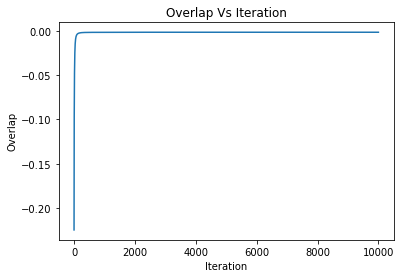

In [3]:
if __name__ == '__main__':
    # INTITIALIZE : J,lambda_1,ti,tf,steps
    k = Krotov(0.1, 5e-1, 0, 8,5000)
    k.Run_Krotov(10000)
    s = Krotov(0.1, 5e-1 ,0, 8,5000)
    s.Run_Krotov(0)
            
    plt.figure(1)
    plt.title('Overlap Vs Iteration')
    plt.ylabel('Overlap')
    plt.xlabel('Iteration')
    plt.plot(np.log(np.abs(k.overlap)/4))
    plt.show()





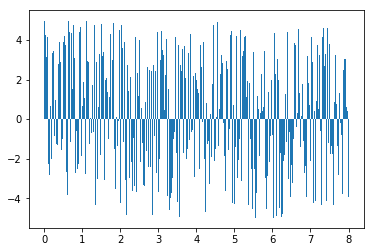

In [9]:
plt.figure(3)
plt.bar(s.t,s.EIZ,linewidth = 0.01, width = s.dt)
plt.show()


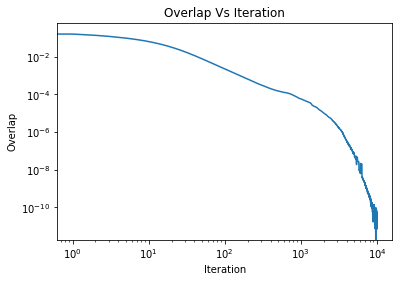

In [10]:
    plt.figure(2)
    plt.title('Overlap Vs Iteration')
    plt.ylabel('Overlap')
    plt.xlabel('Iteration')
    plt.loglog(1-np.abs(k.overlap)/max(np.abs(k.overlap)))
    plt.show()

In [11]:
np.max(np.abs(k.overlap)/4)

0.9982765798570619

In [12]:
np.log(1-np.max(np.abs(k.overlap)/4))

-6.363444507320367

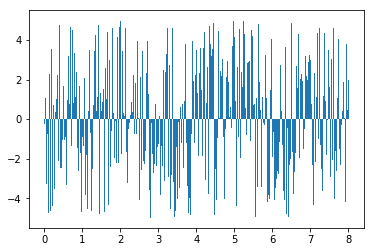

In [19]:
plt.figure(3)
plt.bar(s.t,s.EIZ,linewidth = 0.01, width = s.dt)
plt.show() 

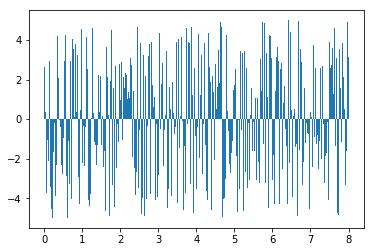

In [13]:
plt.figure(4)
plt.bar(s.t,s.EZI,linewidth = 0.01, width = s.dt)
plt.show() 

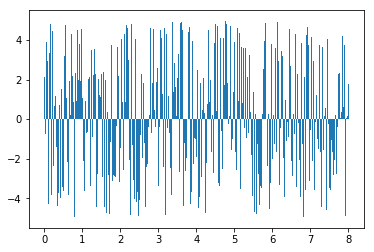

In [20]:
plt.figure(5)
plt.bar(s.t,s.EIY,linewidth = 0.01, width = s.dt)
plt.show() 

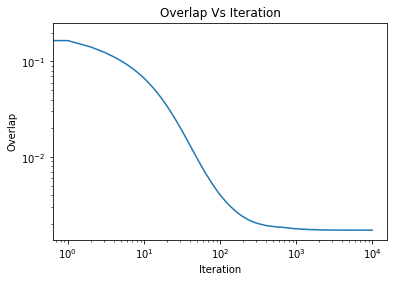

In [17]:
    plt.figure(6)
    plt.title('Overlap Vs Iteration')
    plt.ylabel('Overlap')
    plt.xlabel('Iteration')
    plt.loglog(1-np.abs(k.overlap)/4)
    plt.show()

In [15]:
max(abs(k.overlap)/4)

array([0.99827658])

In [22]:
# Now exporting variables to matlab to have comparsion with GRAPE and other standard Implementations
# This


import scipy.io as sio


Krotov_data = { };
Krotov_data['J'] = k.J
Krotov_data['lambda_1'] = k.lambda_1 
Krotov_data['ti'] = k.ti
Krotov_data['tf'] = k.tf
Krotov_data['steps'] = k.steps
Krotov_data['t'] = k.t
Krotov_data['dt'] = k.dt

Krotov_data['U'] = k.U
Krotov_data['B'] = k.B

Krotov_data['EYI'] = k.EYI;
Krotov_data['EIY'] = k.EIY;
Krotov_data['EIZ'] = k.EIZ;
Krotov_data['EZI'] = k.EZI;

Krotov_data['EYI_tilde'] = k.EYI_tilde;
Krotov_data['EIY_tilde'] = k.EIY_tilde;
Krotov_data['EIZ_tilde'] = k.EIZ_tilde;
Krotov_data['EZI_tilde'] = k.EZI_tilde;

Krotov_data['dis'] = k.dis;
Krotov_data['overlap'] = k.overlap;


Krotov_data['sI'] = k.I;
Krotov_data['sX'] = k.sX;
Krotov_data['sY'] = k.sY;
Krotov_data['sZ'] = k.sZ;
Krotov_data['sIY'] = k.sIY;
Krotov_data['sYI'] = k.sYI;
Krotov_data['sZI'] = k.sZI;
Krotov_data['sIZ'] = k.sIZ;

Krotov_data['sIZ'] = k.delta1
Krotov_data['sIZ'] = k.alpha1 
Krotov_data['sIZ'] = k.delta2 
Krotov_data['alpha2'] = k.alpha2
Krotov_data['delta3'] = k.delta3
Krotov_data['alpha3'] = k.alpha3
Krotov_data['delta4'] = k.delta4
Krotov_data['alpha4'] = k.alpha4 
            
            
            
sio.savemat('Krotov_file', Krotov_data)



